## Test 1.1: take 3 images with random PWM values

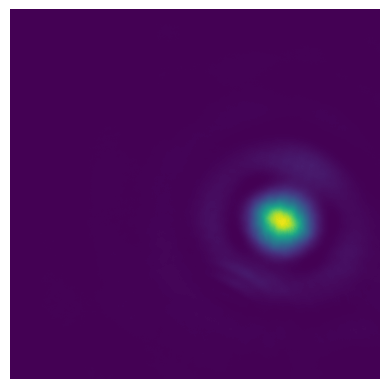

In [14]:
import csv
import numpy as np
import random
import time
from PIL import Image
from imageio import imwrite,imread
import os
from pylablib.devices import Thorlabs
from PIL import Image
import PIL.ImageOps 
import matplotlib.pyplot as plt 
def mkdir(path):
	folder = os.path.exists(path)
	if not folder:                   
		os.makedirs(path)    

from pylablib.devices import Thorlabs
Thorlabs.list_cameras_tlcam()
cam = Thorlabs.ThorlabsTLCamera(serial="14308")
# cam.close()
cam.set_exposure(0.0001) # set exposure to 100ms
# frame = cam.snap() # grab a single frame
cam.set_roi(0,1000,0,1000) # set ROI in the upper left corner
#images = cam.grab(10) # grab 10 frames

i=0
while i<= 2:
    A = np.array([[0],[0],[0],[0],[0]], dtype=np.int32)
#     A = np.random.randint(low=0,high=2000,size=(5,1), dtype=np.int32)   # range form 0 to 3000
    with open('PWM_test.csv', 'w', newline='') as file:
        mywriter = csv.writer(file, delimiter=',')
        mywriter.writerows(A)
    time.sleep(0.1) 
    fig_name = 'pwm='+str(int(A[0]))+'-'+str(int(A[1]))+'-'+str(int(A[2]))+'-'+str(int(A[3]))+'-'+str(int(A[4])) +'-'+str(int(i))
    raw_image_array = cam.grab(1)    # grab 1 frame
    image_array=np.array(raw_image_array)
    squeezed_image_array=image_array.squeeze()
    # image = plt.imshow(squeezed_image_array)
    
    # Display the image without axes
    plt.axis('off')
    plt.imshow(squeezed_image_array)  # Set the desired colormap if needed

    # Save the image without axes
#     plt.savefig('image_without_axes.png', bbox_inches='tight', pad_inches=0)
    plt.savefig(r'C:\Users\plasma\Desktop\jakob_imgs\{fig_name}.png'.format(fig_name=fig_name))  # Save the plot
    
    import pickle # see for usage: https://www.digitalocean.com/community/tutorials/python-pickle-example
    file = open(r'C:\Users\plasma\Desktop\jakob_imgs\{fig_name}.pkl'.format(fig_name=fig_name), "wb")
    pickle.dump(squeezed_image_array, file)
    file.close()
    i=i+1
#can use this to add aberration or add it on pi,see pi_control.py file
cam.close()

In [2]:
image_array.shape

(1, 1000, 1000)

In [3]:
squeezed_image_array.shape

(1000, 1000)

In [15]:
from scipy import stats
from scipy import optimize
from sklearn.metrics import r2_score
from PIL import Image
import glob

def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-((x - mean) / 4 / stddev)**2)
def get_quality_number(image_array):  
 #gaussian fit at centroid with box range +-5
    x=np.linspace(0,1000,1000)

    [m,n]=np.where(image_array==np.max(image_array))
    mode_info_m = stats.mode(m)  ##col

    mode_info_n = stats.mode(n) ##row

    a=int(mode_info_m[0])
    b=int(mode_info_n[0])
    c=5 #box half-thickness
    y_x=0

#     for j in range (a-c,a+c):
#         y_x=y_x+image_array[j,:]/100 #tricky here since if this number is >255 it becomes 0.
#     y_x=(y_x)/c*100

#     y_y=0

#     for j in range (b-c,b+c):
#         y_y=y_y+image_array[:,j]/100
#     y_y=((y_y)/c)*100

    for j in range (a-c,a+c):
        y_x=y_x+image_array[j,:]/100 #tricky here since if this number is >255 it becomes 0.
    y_x=(y_x)/c*100

    y_y=0

    for j in range (b-c,b+c):
        y_y=y_y+image_array[:,j]/100
    y_y=((y_y)/c)*100
    
    popt_x, pcov_x = optimize.curve_fit(gaussian, x, y_x+1,maxfev=500000) # tricky here!!!!! y_x+1
    fitted_y_x=popt_x[0] * np.exp(-((x - popt_x[1]) / 4 / popt_x[2])**2)
    a_x=r2_score(y_x,fitted_y_x)
    popt_y, pcov_y = optimize.curve_fit(gaussian, x, y_y+1,maxfev=500000) # same here!!!! y_y+1
    fitted_y_y=popt_y[0] * np.exp(-((x - popt_y[1]) / 4 / popt_y[2])**2)
    a_y=r2_score(y_y,fitted_y_y)

    s0=abs(a_x*a_y)
    Score=s0
    return Score

s=get_quality_number(squeezed_image_array)
print(s)

    

0.9902327895850168


C:\Users\plasma\AppData\Local\Temp\ipykernel_9268\3124677306.py:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode_info_m = stats.mode(m)  ##col
C:\Users\plasma\AppData\Local\Temp\ipykernel_9268\3124677306.py:16: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  m

In [17]:
imagelist = glob.glob(r'C:/Users/plasma/Desktop/jakob_imgs/*.pkl')
imagelist = imagelist
score=[]
import sys
np.set_printoptions(threshold=sys.maxsize)
print(f"Found {len(imagelist)} images.")
for i in range(len(imagelist)):
    #Image.open(imagelist[i])
    file = open(imagelist[i], "rb")
    loaded_image_array = pickle.load(file)
    file.close()
    # maptplotlib imagenp.array(Image.open(imagelist[i])) # saved squeezed image array
    # Display the image without axes
    # plt.axis('off')
    # plt.imshow(image_array)  # Set the desired colormap if needed
    s=get_quality_number(loaded_image_array)
    score.append(s)
print(score)

Found 6 images.
[0.9853570561616372, 0.9883130804715137, 0.9902327895850168, 0.9513690083445084, 0.5901152052234734, 0.5904117230149575]


C:\Users\plasma\AppData\Local\Temp\ipykernel_9268\3124677306.py:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode_info_m = stats.mode(m)  ##col
C:\Users\plasma\AppData\Local\Temp\ipykernel_9268\3124677306.py:16: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  m

In [18]:
import laserbeamsize as lbs

def get_quality_number2(image_array):
    image_array=np.array(image_array)
    image_array=image_array.squeeze()
    x, y, dx, dy, phi = lbs.beam_size(image_array)
    Ellipticity = min(dx, dy) / max(dx, dy)
    threshold_up_area = (image_array >= np.max(image_array) / 10) + 0  # define a threshold area
    total_pixel = image_array.shape[0] * image_array.shape[1]
    dispersion = total_pixel / np.sum(threshold_up_area)
    quality_number = dispersion * Ellipticity
    return quality_number
imagelist = glob.glob(r'C:/Users/plasma/Desktop/jakob_imgs/*.pkl')
imagelist = imagelist
score=[]
import sys
np.set_printoptions(threshold=sys.maxsize)
print(f"Found {len(imagelist)} images.")
for i in range(len(imagelist)):
    #Image.open(imagelist[i])
    file = open(imagelist[i], "rb")
    loaded_image_array = pickle.load(file)
    file.close()
    # maptplotlib imagenp.array(Image.open(imagelist[i])) # saved squeezed image array
    # Display the image without axes
    # plt.axis('off')
    # plt.imshow(image_array)  # Set the desired colormap if needed
    s=get_quality_number2(loaded_image_array)
    score.append(s)
print(score)


Found 6 images.
[26.028887056171545, 31.611882433590388, 32.05144177039315, 4.079687889226434, 5.454656320818955, 4.945638055043149]


In [13]:
cam.close()